In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure

## Data

In [133]:
#path martim
path = "../../../../DadosProj/UTKFace/"
#path alex
#ath = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


### Extraction with PreProcessing

**Changes to images with opencv methods**

- Obtain better contrast for images normalizing the ranges for colors for a pixel between 0 and 255
 - instance = cv2.normalize(instance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

- Converting to YUV color model, equalizing color histogram to modify 
- distribution of colors taking luminosity into account and
- reconverting to RBG after doing histogram equalization
    - img_yuv = cv2.cvtColor(instance, cv2.COLOR_BGR2YUV)
    - img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    - instance = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

In [134]:
images = []
ages = []
genders = []
ethnicities = []
counter = 0

for file in files:
    if counter == 5000:
        break
    
    image = cv2.imread(path+file)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, dsize=(200, 200))
    image = image / 255.0
    
    images.append(image)
    delimit = file.split('_')
    ages.append(int(delimit[0]))
    # first number is age (0-116 possible values)
    genders.append(int(delimit[1]))
    # second number is gender (0 for male, 1 for female)
    ethnicities.append(int(delimit[2]))
    # third number is ethnicity 
    # (0 for white, 1 for black, 2 for asian, 3 for indian, 4 for any other ethnicity)

    counter += 1

### Data Analysis

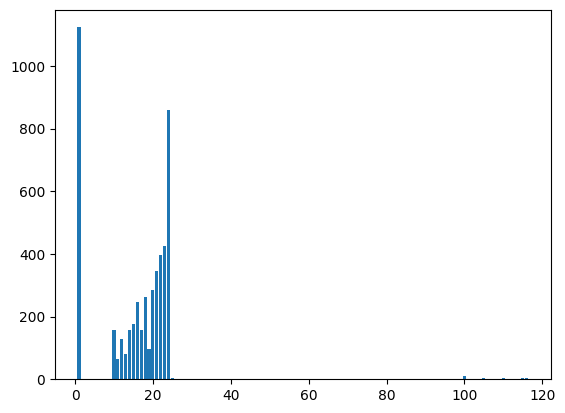

Max value: 116


In [135]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

In [136]:
img_all = pd.DataFrame()
img_all["age"] = ages
img_all["ethnicity"] = ethnicities
img_all["gender"] = genders
#To add the extra features from using cnn/opencv feat extraction

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = ages

#display(img_all)
#display(img_gender)
#display(img_age)

In [137]:
print("unique values for age are", img_age.age.unique())
print("unique values for ethnicity are", img_all.ethnicity.unique())
print("unique values for gender are", img_gender.gender.unique())

unique values for age are [100 101 103 105  10 110 111 115 116  11  12  13  14  15  16  17  18  19
   1  20  21  22  23  24  25]
unique values for ethnicity are [0 2 1 3 4]
unique values for gender are [0 1]


In [138]:
#var_1 = [1, 2, 3]
#%store var_1
#no outro .ipynb --> %store -r var_1

Stored 'var_1' (list)


Gender: 1 Age: 105 Ethnicities 0


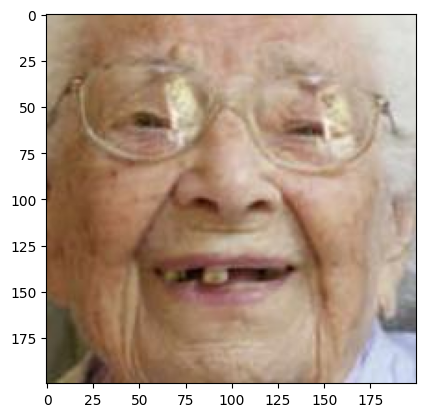

In [139]:
def display(img):
    plt.imshow(img)
    plt.show()
    
idx = 15
if idx < len(images):
    sample = images[idx]
    print("Gender:", genders[idx], "Age:", ages[idx], "Ethnicities", ethnicities[idx])
    display(sample)
else:
    print(f"Index {idx} is out of range for the list of {len(images)} images")

## Feature extraction and Normalization

- Sure! This code extracts Histogram of Oriented Gradients (HOG) features from a list of preprocessed images, normalizes the features to have zero mean and unit variance, and stores them in a NumPy array called hog_features_norm

### HOG

In [85]:
gray_images = np.array([rgb2gray(image) for image in images]) #just in case we need the images in greys

In [86]:
image_check = images[25]

# define HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# compute HOG features and visualize them
hog_features, hog_image = hog(image_check, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, visualize=True,channel_axis=2)



# rescale image intensity for better visualization
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# display HOG features
plt.imshow(hog_image)
plt.show()

TypeError: hog() got an unexpected keyword argument 'multichannel'

In [87]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

In [88]:
for i, arr in enumerate(hog_features_norm):
    print(f"Descriptor array {i} shape: {arr.shape}")

Descriptor array 0 shape: (20736,)
Descriptor array 1 shape: (20736,)
Descriptor array 2 shape: (20736,)
Descriptor array 3 shape: (20736,)
Descriptor array 4 shape: (20736,)
Descriptor array 5 shape: (20736,)
Descriptor array 6 shape: (20736,)
Descriptor array 7 shape: (20736,)
Descriptor array 8 shape: (20736,)
Descriptor array 9 shape: (20736,)
Descriptor array 10 shape: (20736,)
Descriptor array 11 shape: (20736,)
Descriptor array 12 shape: (20736,)
Descriptor array 13 shape: (20736,)
Descriptor array 14 shape: (20736,)
Descriptor array 15 shape: (20736,)
Descriptor array 16 shape: (20736,)
Descriptor array 17 shape: (20736,)
Descriptor array 18 shape: (20736,)
Descriptor array 19 shape: (20736,)
Descriptor array 20 shape: (20736,)
Descriptor array 21 shape: (20736,)
Descriptor array 22 shape: (20736,)
Descriptor array 23 shape: (20736,)
Descriptor array 24 shape: (20736,)
Descriptor array 25 shape: (20736,)
Descriptor array 26 shape: (20736,)
Descriptor array 27 shape: (20736,)
De

- For each preprocessed image in images, extract the HOG features using the hog() function from scikit-image. The orientations, pixels_per_cell, and cells_per_block parameters control the number of orientations, the size of the cells, and the number of cells per block used in the feature extraction process. The transform_sqrt parameter applies power law compression to normalize the local contrast of the image. The feature_vector parameter flattens the HOG descriptor into a 1D array. The multichannel and channel_axis parameters are used to indicate that the input image has three channels. The resulting HOG feature is then appended to the hog_features list.

#### SVM

In [89]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 400
Samples in Testing: 100


In [91]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.81


## ORB (Oriented FAST and Rotated BRIEF)

In [92]:
image_check = images[1]

orb = cv2.ORB_create(500)

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<1,-1,-1>,struct cv::impl::A0x981fb336::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [93]:

#retirar keypoints aleatoriamente de imagens com keypoints acima de um limiar decidido
#e ter uma quantidade minima definida para os keypoints

orb = cv2.ORB_create()
orb_features = []
Genders = []
MIN_KEYPOINTS = 500
MAX_KEYPOINTS = 500

for i, img in enumerate(images):
    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(image_check, keypoints) #se houver problemas nesta linha ver esta duvida https://stackoverflow.com/questions/55128386/python-opencv-depth-of-image-unsupported-cv-64f
    
    if len(keypoints) < MIN_KEYPOINTS:
        continue  
    if len(keypoints) > MAX_KEYPOINTS:
        continue 
    
    orb_features.append(np.ndarray.flatten(descriptors))
    Genders.append(genders[i]) 

error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<1,-1,-1>,struct cv::impl::A0x981fb336::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [437]:
len(orb_features)

0

In [438]:
len(Genders)

0

In [430]:
for i, arr in enumerate(orb_features):
    print(f"Descriptor array {i} shape: {arr.shape}")

Descriptor array 0 shape: (1600,)
Descriptor array 1 shape: (1600,)
Descriptor array 2 shape: (1600,)
Descriptor array 3 shape: (1600,)
Descriptor array 4 shape: (1600,)
Descriptor array 5 shape: (1600,)
Descriptor array 6 shape: (1600,)
Descriptor array 7 shape: (1600,)
Descriptor array 8 shape: (1600,)
Descriptor array 9 shape: (1600,)
Descriptor array 10 shape: (1600,)
Descriptor array 11 shape: (1600,)
Descriptor array 12 shape: (1600,)
Descriptor array 13 shape: (1600,)
Descriptor array 14 shape: (1600,)
Descriptor array 15 shape: (1600,)
Descriptor array 16 shape: (1600,)
Descriptor array 17 shape: (1600,)
Descriptor array 18 shape: (1600,)
Descriptor array 19 shape: (1600,)
Descriptor array 20 shape: (1600,)
Descriptor array 21 shape: (1600,)
Descriptor array 22 shape: (1600,)
Descriptor array 23 shape: (1600,)
Descriptor array 24 shape: (1600,)
Descriptor array 25 shape: (1600,)
Descriptor array 26 shape: (1600,)
Descriptor array 27 shape: (1600,)
Descriptor array 28 shape: (16

In [431]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

#### SVM

In [432]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, Genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 64
Samples in Testing: 16


In [433]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [434]:
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5


## BRISK (Binary Robust Invariant Scalable Keypoints) 

In [101]:
import cv2
import numpy as np
import glob

# Create BRISK detector
brisk = cv2.BRISK_create()

# Initialize list to store descriptors
brisk_features = []

# Loop over input images
for img in images:
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = brisk.detectAndCompute(img, None)
    
    # Add descriptors to list
    brisk_features.append(descriptors)

# Concatenate descriptors into feature matrix
X = np.vstack(brisk_features)

# Create labels for each image
y = np.array([0, 1, 2, ...])  # Replace with actual labels for each image



ValueError: Found input variables with inconsistent numbers of samples: [8088, 4]

In [102]:
X = np.load('features.npy')
y = np.load('labels.npy')

# Check the shapes of the arrays
print(X.shape)  # should print (8088, n_features)
print(y.shape)  # should print (8088,)

FileNotFoundError: [Errno 2] No such file or directory: 'features.npy'

In [ ]:
# Train support vector machine on feature matrix X and labels y
svm = svm.SVC(kernel='linear', C=1.0)
svm.fit(X, y)

### CNN

#### VGG 16 https://www.youtube.com/watch?v=IuoEiemAuIY

#### Normalization of each RGB array of each image

In [147]:
images

[array([[[0.84313725, 0.80784314, 0.78823529],
         [0.83529412, 0.8       , 0.78039216],
         [0.83137255, 0.79607843, 0.77647059],
         ...,
         [0.34901961, 0.36862745, 0.39215686],
         [0.35294118, 0.36862745, 0.41176471],
         [0.36470588, 0.38039216, 0.42352941]],
 
        [[0.83529412, 0.8       , 0.78039216],
         [0.82745098, 0.79215686, 0.77254902],
         [0.83921569, 0.80392157, 0.78431373],
         ...,
         [0.35294118, 0.37254902, 0.39607843],
         [0.35686275, 0.37254902, 0.41568627],
         [0.36862745, 0.38431373, 0.42745098]],
 
        [[0.82745098, 0.79215686, 0.77254902],
         [0.80784314, 0.77254902, 0.75294118],
         [0.82352941, 0.78823529, 0.76862745],
         ...,
         [0.36078431, 0.37254902, 0.4       ],
         [0.36470588, 0.37254902, 0.41960784],
         [0.38039216, 0.38823529, 0.43529412]],
 
        ...,
 
        [[0.92941176, 0.9254902 , 0.94901961],
         [0.92941176, 0.9254902 , 0.94901

In [148]:
X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)#variar a percentagem split
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

#### VGG 16

In [149]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in VGG_model.layers:
	layer.trainable = False
	
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [150]:
X_train_stacked = np.stack(X_train)

In [151]:
feature_extractor=VGG_model.predict(X_train_stacked)

125/125 [==============================] - 169s 1s/step


In [152]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [153]:
features

array([[0.        , 0.        , 0.04969606, ..., 0.        , 0.2321488 ,
        0.        ],
       [0.23889402, 0.        , 0.        , ..., 0.        , 0.8162222 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.38121426,
        0.        ],
       ...,
       [0.06231795, 0.        , 0.22643217, ..., 0.        , 0.6550393 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01503369, 0.48796287,
        0.        ],
       [0.        , 0.        , 0.4909249 , ..., 0.        , 0.7222227 ,
        0.        ]], dtype=float32)

In [154]:
clf = SVC()
clf.fit(features, y_train)

# Evaluate the classifier on the testing data
#accuracy = clf.score(X_test, y_test)
#print("Accuracy:", accuracy)

SVC()

In [155]:
accuracy = clf.score(features, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.845


#### VGG FACE

In [ ]:
#from keras_vggface.vggface import VGGFace
# Load the VGGFace model
#model = VGGFace(model='resnet50', include_top=False, input_shape=(200, 200, 3), pooling='avg')

In [ ]:
"""import numpy as np

# Define a function to extract features from an image
def extract_features(img, model):
    features = model.predict(img)
    return features

# Extract features from all images in the dataset
features_list = []
for image_path in image_paths:
    features = extract_features(image_path, model)
    features_list.append(features)
"""

In [ ]:
#é boa ideia fazermos transfer learning sem peso computacional do nosso lado nesta parte ao usarmos CNNs com weights pretreinados?

#